# Apply EOQ, ROP, TC in case quantity discount model

For product A, Having a number of demand during a year, 250 work days.<br>Inventory in warehouses have 800 units

Supplier provide discount per unit due to purchase quantity with order condition
* 5.0฿ per unit for purchase 1 - 4 pallet -> not over 4 * 48 * 12 == 2,304 units
* 4.5฿ per unit for purchase 5 - 8 pallet -> not over 8 * 48 * 12 == 4,608 units
* 4.0฿ per unit for purchase over 8 pallet -> more than 4,608 units
* The palett have contain maximum 48 boxes
* The box have contain 12 inventory units
* Minimum order quantity is 1 pallet -- 576 units
* Minimum lot size is 1 box -- 12 units
* each of orders have average 7 days to delivers.

For the operation cost having:
* Set up cost: once order is 300฿
* Holding cost: holding cost 20% of inventory cost per units

Consider to EOQ of each price, 5฿, 4.5฿, 4฿. Did EOQ from case is true?<br>
Based on Total cost, how many units should orders with minimum cost.

Model price break:
1. Holding cost are constant
  - compute EOQ
  - compute the TC for all price break with lower unit cost
2. Holding cost as % of price
  - start with lowest unit price, compute EOQ
  - if EOQ in lowest price range - finished
  - compute total cost for next lower price ranges

In [13]:
# @markdown import python package

import math, random
import os, openpyxl
import scipy.stats as stats
import numpy as np
import pandas as pd

# plot module
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [14]:
from MinimumLotSize import LotSize as lot
from SafetyStock import SafetyStock as sts
from ReOrderPoint import ROP as rop
from EconomicOrderQuantity import EOQ as eoq
from TotalCost import TC as ttc

assert sts.normdist(Demand=500, Leadtime=3, service_level=90) == 0

## Data

In [15]:
demand_df = pd.read_excel('data.xlsx', sheet_name='demand',
                          engine='openpyxl', header=0,usecols="A")
print("Demand profile:")
demand_df.describe().round(2).T

Demand profile:


,count,mean,std,min,25%,50%,75%,max
demand,250.0,100.1,7.94,73.0,95.25,100.0,106.0,119.0


In [16]:
# Plot data profile func 
def plot_data_profile(data, label):
    fig, axs = plt.subplots(2, figsize=(10, 6))
    axs[0].plot(data, label=label, c="#979797")
    axs[0].axhline(y=data.mean(), c = "g", ls="--", label=f"average {label}")
    axs[0].set_title(f"Dynamic of {label}")
    axs[0].legend(loc=7);

    axs[1].hist(data, color ="#979797")
    axs[1].set_title(f"Frequence of {label}");

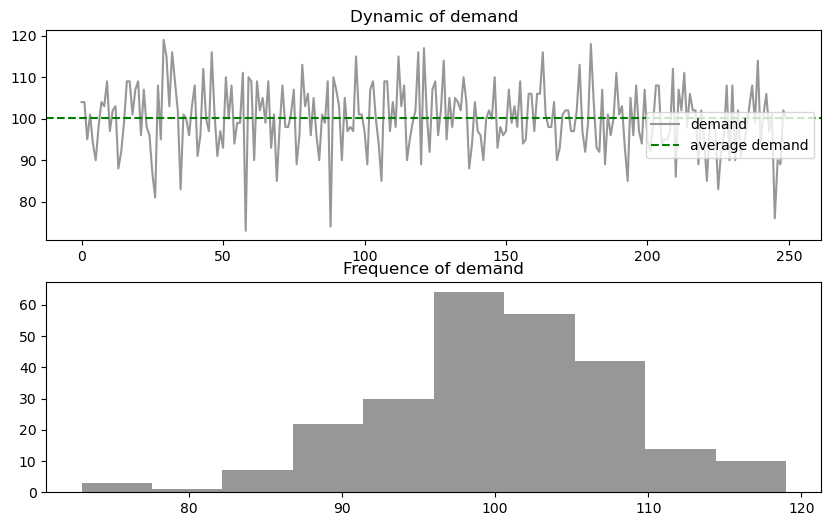

In [17]:
plot_data_profile(demand_df["demand"], "demand")

## Leadtime
- Generate leadtime

In [18]:
# @markdown Generate order leadtime
leadtime_day = []
random.seed(42)
for i in np.random.normal(loc=4, scale=1.5, size=11):
  leadtime_day.append(round(i))

leadtime_days = pd.DataFrame(data={"leadtime":leadtime_day}, index = range(11))

print("Leadtime profile:")
leadtime_days.describe().round(2).T

Leadtime profile:


,count,mean,std,min,25%,50%,75%,max
leadtime,11.0,4.82,0.98,3.0,4.0,5.0,5.5,6.0


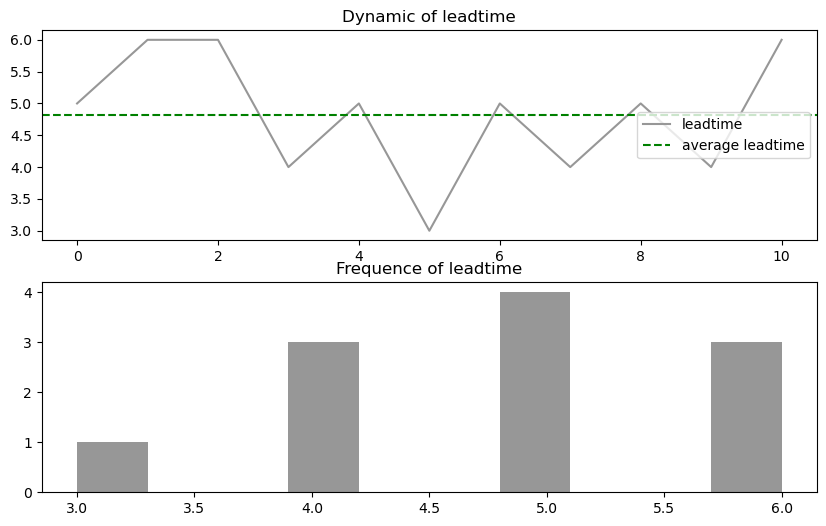

In [19]:
plot_data_profile(leadtime_days["leadtime"], "leadtime")

## Determine EOQ

In [20]:
# @markdown determine parameter

# Determine Inventory in warehouse
stock_zero = 1800

# Determine Operation cost
setup_c = 300
holding_c = 0.2

discount_price = {5.0 : 576,
                  4.5 : 2304,
                  4.0 : 4608}

print(f"""
      Work day = {len(demand_df)} days
      Operation Cost:
        - Set up cost = {setup_c}฿
        - Holding cost = {holding_c*100}% of inventory price""");

year_demand = demand_df["demand"].sum()
I = year_demand - stock_zero

print(f"Year Demand ({len(demand_df)} days) =",year_demand)
print("Inventory on hand =", stock_zero)
print("Inventory require to order =", I)


      Work day = 250 days
      Operation Cost:
        - Set up cost = 300฿
        - Holding cost = 20.0% of inventory price
Year Demand (250 days) = 25026
Inventory on hand = 1800
Inventory require to order = 23226


### Perform EOQ for each product price

In [21]:
# @markdown Apply EOQ for discount
# Calculate EOQ for each cost range
print("EOQ at each price")
print("---")

for price in discount_price:
  print(f"Order more than {discount_price.get(price)} units, product price = {price}฿.\nEOQ =",
        round(eoq(D = I, S=setup_c, H=holding_c*(price)), 2), "units")
  print("----------");

EOQ at each price
---
Order more than 576 units, product price = 5.0฿.
EOQ = 3733.04 units
----------
Order more than 2304 units, product price = 4.5฿.
EOQ = 3934.97 units
----------
Order more than 4608 units, product price = 4.0฿.
EOQ = 4173.67 units
----------


Let's see total cost of EOQ by using quantity discount model compare with total cost of purchase unit at lowest cost.

Total cost model
> Total Cost = Set up cost + Holding cost + Purchase cost

In [22]:
eoq_price = eoq(D = I, S=setup_c, H=holding_c*4.5)
eoq_ord = lot.round_lot_size( eoq_price, 12)
min_4_ord = discount_price.get(4)
eoq_cost = ttc(D=I, C=4.5, S=setup_c, H=holding_c*4.5, Q=eoq_ord)
minord_cost = ttc(D=I, C=4, S=setup_c, H=holding_c*4, Q=discount_price.get(4))

print(f"True economic order quantity is {round(eoq_price, 2)} units.\nwith lot size 12 units, order quantity will be {eoq_ord} units.")
print(f"Order quantity at eoq ({eoq_ord} units) is lower than order at mininmum price ({min_4_ord} units) at {min_4_ord - eoq_ord} units")
print("-----")
print(f"Total cost to order at economic order quantity ({eoq_ord} units with 4.5฿) is {eoq_cost}฿")
print(f"Total cost to order at minimum price ({min_4_ord} units with 4.0฿) is {minord_cost}฿")

True economic order quantity is 3934.97 units.
with lot size 12 units, order quantity will be 3936 units.
Order quantity at eoq (3936 units) is lower than order at mininmum price (4608 units) at 672 units
-----
Total cost to order at economic order quantity (3936 units with 4.5฿) is 108058.47฿
Total cost to order at minimum price (4608 units with 4.0฿) is 96259.31฿


In [23]:
# @markdown Campare Total cost in each price
for i in discount_price:
  print(f"Total cost to order at {discount_price.get(i)} units with price {i}฿ is", str(ttc(D=I, C=i, S=setup_c, H=holding_c*i, Q=discount_price.get(i)))+"฿")
  print(f"Numbers of order: {math.ceil(I/discount_price.get(i))} orders")
  print("-----")
print(f"Total cost to order at EOQ {eoq_ord} units with price 4.5฿ is {eoq_cost}฿")
print(f"Numbers of order: {math.ceil(I/eoq_ord)} orders")
print("-----")

Total cost to order at 576 units with price 5.0฿ is 128514.88฿
Numbers of order: 41 orders
-----
Total cost to order at 2304 units with price 4.5฿ is 108578.02฿
Numbers of order: 11 orders
-----
Total cost to order at 4608 units with price 4.0฿ is 96259.31฿
Numbers of order: 6 orders
-----
Total cost to order at EOQ 3936 units with price 4.5฿ is 108058.47฿
Numbers of order: 6 orders
-----


Total cost of purchase at EOQ (3936 unite) is more than purchase at minimum price (4608 units).<br>
Let's see if there are total cost smaller by what-if simulation.

### What-if Analysis

In [24]:
# @markdown Inventory cost modeling
# quantity range set up
min_qty = 1 * 48 * 12 # minimum order quantity -> 576 //1 pallet with 48 box and 12 bags init
max_qty = 9 * 48 * 12 # max order quantity -> 5184 // 9 pallet
step_qty = 12 # step increase by minimum lot 12 -> box

cost_plot = pd.DataFrame()
cost_plot["quantity"] = range(min_qty, max_qty+1, step_qty)
cost_plot["inv_price"] = cost_plot["quantity"].apply(lambda x: 4 if x > discount_price.get(4) else 4.5 if x > discount_price.get(4.5) else 5)

cost_plot["inventory_cost"] =   (cost_plot["inv_price"]*I).round(2)
cost_plot["holding_cost"] = ttc(D=I, C=0, S=0, H=holding_c*cost_plot["inv_price"], Q=cost_plot["quantity"])
cost_plot["setup_cost"] =   ttc(D=I, C=0, S=setup_c, H=0, Q=cost_plot["quantity"])

cost_plot["operation_cost"] = cost_plot["holding_cost"] + cost_plot["setup_cost"]
cost_plot["TC"] = (cost_plot["inventory_cost"] + cost_plot["holding_cost"] + cost_plot["setup_cost"]).round(2)

print(f"""
    Simulation parameter:\n
      Start order unit: {min_qty} units
      Stop order unit: {max_qty} units
      Increase unit: {step_qty} units
""")
cost_plot


    Simulation parameter:

      Start order unit: 576 units
      Stop order unit: 5184 units
      Increase unit: 12 units



,quantity,inv_price,inventory_cost,holding_cost,setup_cost,operation_cost,TC
0,576,5.0,116130.0,288.0,12096.88,12384.88,128514.88
1,588,5.0,116130.0,294.0,11850.00,12144.00,128274.00
2,600,5.0,116130.0,300.0,11613.00,11913.00,128043.00
3,612,5.0,116130.0,306.0,11385.29,11691.29,127821.29
4,624,5.0,116130.0,312.0,11166.35,11478.35,127608.35
...,...,...,...,...,...,...,...
380,5136,4.0,92904.0,2054.4,1356.66,3411.06,96315.06
381,5148,4.0,92904.0,2059.2,1353.50,3412.70,96316.70
382,5160,4.0,92904.0,2064.0,1350.35,3414.35,96318.35
383,5172,4.0,92904.0,2068.8,1347.22,3416.02,96320.02


In [25]:
# @markdown Model minimum cost
print("Minimum cost model:")
cost_plot[cost_plot["TC"] == cost_plot["TC"].min()]

Minimum cost model:


,quantity,inv_price,inventory_cost,holding_cost,setup_cost,operation_cost,TC
337,4620,4.0,92904.0,1848.0,1508.18,3356.18,96260.18


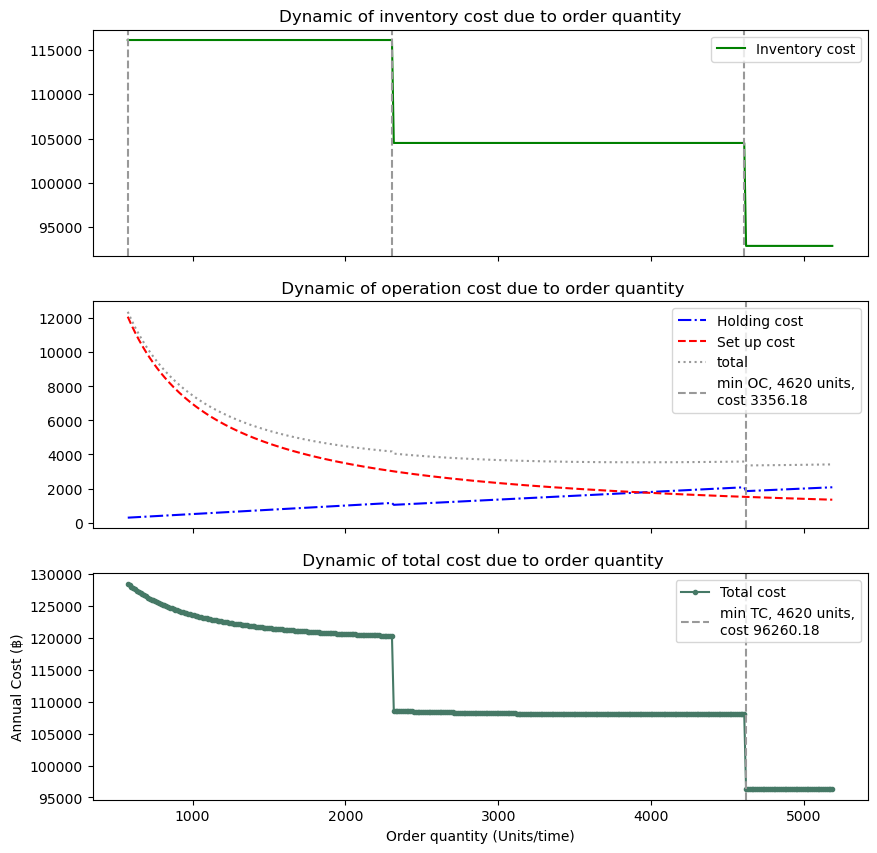

In [26]:
# @markdown Inventory cost plot
min_tc_cost = min(cost_plot["TC"])
min_tc = cost_plot[cost_plot["TC"] == min_tc_cost]["quantity"].min()

min_oc_cost = min(cost_plot["operation_cost"])
min_oc = cost_plot[cost_plot["operation_cost"] == min_oc_cost]["quantity"].min()

# Plot model
fig, axs = plt.subplots(3, figsize=(10, 10), sharex=True)
axs[0].plot(cost_plot["quantity"], cost_plot["inventory_cost"], label="Inventory cost", c = "g", ls = "-")
for i in discount_price: #qty_range
  axs[0].axvline(x=discount_price.get(i), c = "#999999", ls="--")
axs[0].set_title("Dynamic of inventory cost due to order quantity")
axs[0].legend(loc=1)

axs[1].plot(cost_plot["quantity"], cost_plot["holding_cost"], label="Holding cost", c = "b", ls = "-.")
axs[1].plot(cost_plot["quantity"], cost_plot["setup_cost"], label="Set up cost", c = "r", ls = "--")
axs[1].plot(cost_plot["quantity"], cost_plot["operation_cost"], label="total",c = "#999999", ls = ":")
axs[1].axvline(x=min_oc, c = "#999999", ls="--", label = f"min OC, {min_oc} units,\ncost {round(min_oc_cost, 2)}")
axs[1].set_title("\n Dynamic of operation cost due to order quantity")
axs[1].legend(loc=1)

axs[2].plot(cost_plot["quantity"], cost_plot["TC"], label="Total cost", c="#467966", ls="-", marker='.')
axs[2].axvline(x=min_tc, c = "#999999", ls="--", label = f"min TC, {min_tc} units,\ncost {round(min_tc_cost, 2)}")
axs[2].set_title("\n Dynamic of total cost due to order quantity")
axs[2].legend(loc=1)

plt.xlabel("Order quantity (Units/time)")
plt.ylabel("Annual Cost (฿)");

In [27]:
# @markdown
save_eoq = round((cost_plot[cost_plot["quantity"] == lot.round_lot_size(x=eoq_ord, min_size=step_qty) ]["TC"].max() - min_tc_cost),2)
print(f"From cost model, order quantity at {min_tc} units can save {save_eoq}฿ from order quantity at EOQ, {eoq_ord} units." )

From cost model, order quantity at 4620 units can save 11798.29฿ from order quantity at EOQ, 3936 units.


## Determine ROP

In [28]:
# prepare dataframe
zero = pd.DataFrame(data=[0], index=[0])
plan_df = pd.concat([zero, demand_df['demand']], ignore_index=True)
plan_df.columns = ["demand"]

leadtime_df = pd.concat([zero, leadtime_days["leadtime"]], ignore_index=True, )
leadtime_df.columns = ["leadtime"]

In [29]:
# @markdown Simulate inventory level from Re-Order Point and Order quantity
df = plan_df.copy()

# Initial stock on day 0
stock_zero # 1800
min_tc # eoq 4620
model_lt = math.ceil(leadtime_days["leadtime"].mean())
model_ss = math.ceil(sts.normdist(demand_df["demand"], leadtime_days["leadtime"], 95))
model_rop = math.ceil(rop(demand_df["demand"], Leadtime=leadtime_days["leadtime"], Safety_Stock = model_ss))
product_price = 4
# Create a new column 'on_hand' with initial stock
df['on_hand'] = stock_zero
df['rop_check'] = False
df['order_arrive'] = 0
df['onhand_cost'] = 0

onhand = []
ropcheck = []
order_arr = []

# loop calculate
for i in df.index:

  l_index = int(sum(df['rop_check'][:i]))
  leadtime = int(leadtime_df.loc[l_index, ["leadtime"]])

  # Check if order arrive -> if rop.shift(leadtime) == True then onhand + order qty
  if i < model_lt:
    order_arr.append(0)
  elif df["rop_check"][i - leadtime] == True:
    order_arr.append(min_tc)
  else:
    order_arr.append(0)
  df['order_arrive'][i] = order_arr[i]

  # calculate on-hand unit after suse in demand and order arrive
  
  if i == 0:
    onhand.append(stock_zero)
  else:
    onhand.append(df["on_hand"][i-1]  - df["demand"][i] + df['order_arrive'][i])
  df["on_hand"][i] = onhand[i]
  df['onhand_cost'][i] = df["on_hand"][i]*product_price

  # Check left onhand is it less than rop, and if less check if there are ordered (Leadtime)
  if (df["on_hand"][i] <= model_rop) & (sum(ropcheck[i-leadtime : i]) == 0):
    ropcheck.append(True)
  else:
    ropcheck.append(False)
  df["rop_check"][i] = ropcheck[i]

print("Re-Order Poing and Safety stock at service level 95%\nROP =", model_rop, "units\nSafety Stock =", model_ss,"units")

Re-Order Poing and Safety stock at service level 95%
ROP = 640 units
Safety Stock = 157 units


In [30]:
print("Schedule which include the order day and order arrive");
df[(df['rop_check']==True) | (df["order_arrive"]>0)].replace({True: "order", False: 'arrive'})

Schedule which include the order day and order arrive


,demand,on_hand,rop_check,order_arrive,onhand_cost
12,102,599,order,0,2396
17,109,4728,arrive,4620,18912
58,111,564,order,0,2256
64,102,4591,arrive,4620,18364
104,109,586,order,0,2344
110,97,4612,arrive,4620,18448
150,96,564,order,0,2256
154,103,4778,arrive,4620,19112
196,96,565,order,0,2260
201,95,4684,arrive,4620,18736


## Model summary

In [31]:
# @markdown
inv_end = df.iloc[-1, 1]
turn_over = round(df["demand"].sum()/((stock_zero+inv_end)/2), 2)
inv_day = round(len(demand_df)/turn_over, 2)
inv_avg = (df["on_hand"].mean()).round(2)
inv_cost_avg = round( df['onhand_cost'].mean(),2)
orderss = df["rop_check"].sum()

loss_sale = ((df[df["on_hand"] <= 0]["on_hand"].count())/len(demand_df)).round(4)

max_index = df[df["order_arrive"]>0].index.to_list()
min_index = [x-1 for x in max_index]
avg_min_onhand = round(df.loc[min_index,"on_hand"].mean(),2)
avg_max_onhand = round(df.loc[max_index,"on_hand"].mean(),2)

print(f"Number of order = {orderss} orders") 
print(f"Inventory in the end of period: {inv_end} units")
print(f"Inventory turn over = {turn_over} cycle")
print(f"Inventory day = {inv_day} days")
print("----------")
print(f"Average maximum inventory carry = {avg_max_onhand} units")
print(f"Average minimum inventory carry = {avg_min_onhand} units")
print(f"Average inventory on-hand carry = {inv_avg} units")
print(f"Average inventory cost carry = {inv_cost_avg}฿")

print("----------")
print(f"Loss sale ratio = {loss_sale*100}%")
df[df["on_hand"] <= 0]

Number of order = 6 orders
Inventory in the end of period: 4494 units
Inventory turn over = 7.95 cycle
Inventory day = 31.45 days
----------
Average maximum inventory carry = 4724.0 units
Average minimum inventory carry = 205.17 units
Average inventory on-hand carry = 2390.95 units
Average inventory cost carry = 9563.81฿
----------
Loss sale ratio = 0.0%


,demand,on_hand,rop_check,order_arrive,onhand_cost


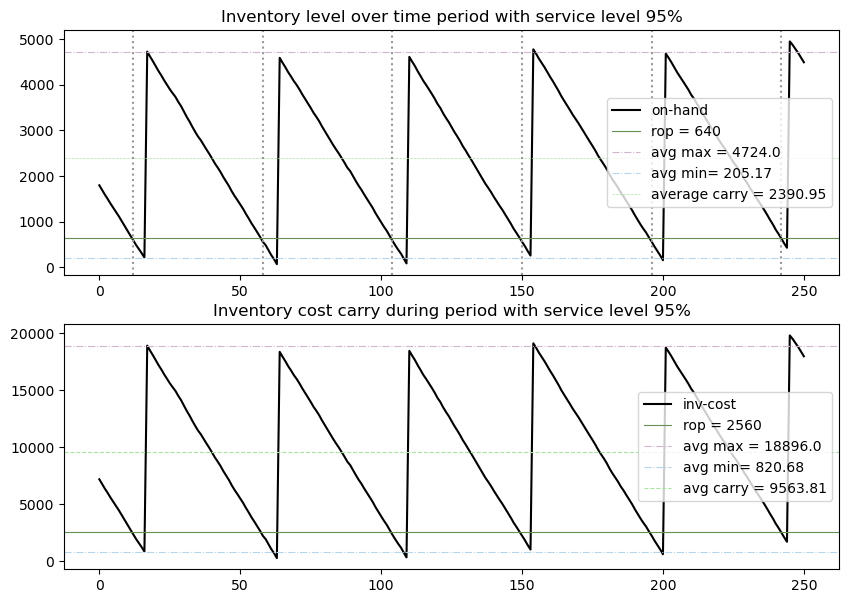

In [32]:
# @markdown Inventory level model plot ls=95%
fig, axs = plt.subplots(2, figsize=(10, 7))

axs[0].plot(df["on_hand"], label="on-hand", c='k')
axs[0].axhline(y=model_rop, label=f"rop = {model_rop}", c='#659053', ls='-', lw=0.8)
axs[0].axhline(y= avg_max_onhand, label=f"avg max = {avg_max_onhand}", c='#d1b4ce', ls='-.', lw=0.8)
axs[0].axhline(y= avg_min_onhand, label=f"avg min= {avg_min_onhand}", c='#b6d5eb', ls='-.', lw=0.8)
axs[0].axhline(y=inv_avg , label=f"average carry = {inv_avg}", c='#a8e4a0', ls='--', lw=0.5)
for i in df[df["rop_check"]==True].index:
  axs[0].axvline(x=i,  ymax= 130 ,c='#999999',ls=":")
axs[0].set_title("Inventory level over time period with service level 95%")
axs[0].legend(loc=7);

axs[1].plot(df["onhand_cost"], label="inv-cost", c='k', ls="-")
axs[1].axhline(y=model_rop*4, label=f"rop = {model_rop*4}", c='#659053', ls='-', lw=0.8)
axs[1].axhline(y=avg_max_onhand*4, label=f"avg max = {avg_max_onhand*4}", c='#d1b4ce', ls='-.',lw=0.8)
axs[1].axhline(y=avg_min_onhand*4, label=f"avg min= {avg_min_onhand*4}", c='#b6d5eb', ls='-.', lw=0.8)
axs[1].axhline(y=inv_cost_avg, label=f"avg carry = {inv_cost_avg}", c='#a8e4a0', ls='--', lw=0.8)
axs[1].set_title("\nInventory cost carry during period with service level 95%")
axs[1].legend(loc=7);